# ML classification
- load tokenizers
- tokenize data
- load data, split into train, test
- pick classifier (by running multiple tests)
- predict on test data (to determine the accuracy)
- pick the best vocabulary (tokenizer) to use


https://huggingface.co/transformers/preprocessing.html

## Imports and Paths

In [15]:
import os
import IPython

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tokenizers import CharBPETokenizer
from tokenizers import ByteLevelBPETokenizer

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn import metrics
from keras.preprocessing.sequence import pad_sequences

from yellowbrick.classifier import ROCAUC

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import uniform

from hpsklearn import HyperoptEstimator

RANDOM_STATE = 42

In [16]:
RootFolder = "/home/lieberze/DP/Thesis/"

DataFolder = os.path.abspath(os.path.join(RootFolder, 'model_training/data/512_bp_for_encoding/'))
FileToEncode_1M = os.path.abspath(os.path.join(DataFolder, 'All_equal_shuffled_1M.txt'))
FileToEncode_3M = os.path.abspath(os.path.join(DataFolder, 'All_equal_shuffled_3M.txt'))

AttemptFolder = os.path.abspath(os.path.join(RootFolder, "tokenizery_2_attempt/"))
EncodedFolder_1M = os.path.abspath(os.path.join(AttemptFolder, "data/sample/Encoding/Encoded_512bp_1M_lines/"))

FolderName = "All_genomes_sample"
name = "01_CharBPE"
CharBPE = os.path.abspath(os.path.join(AttemptFolder, f'{name}/{FolderName}'))
All_512_BPE = os.path.abspath(os.path.join(CharBPE, 'All_512/'))
All_1000_BPE = os.path.abspath(os.path.join(CharBPE, 'All_1000/'))
name = "02_ByteLevelBPE"
ByteLevelBPE = os.path.abspath(os.path.join(AttemptFolder, f'{name}/{FolderName}'))
All_512_BLBPE = os.path.abspath(os.path.join(ByteLevelBPE, 'All_512/'))
All_1000_BLBPE = os.path.abspath(os.path.join(ByteLevelBPE, 'All_1000/'))

## Tokenize Data

In [17]:
def LoadTokenizer(TokenizerPath, Tokenizer):
    vocab = f"{TokenizerPath}/vocab.json"
    merges = f"{TokenizerPath}/merges.txt"
    tokenizer = Tokenizer(vocab, merges)    
    return tokenizer

def ModifyPath(TokenizerPath, TokenizerName, FolderForEncoded):
    EncodedPath = TokenizerPath.strip("/").split("/")[-2:]
    EncodedPath = TokenizerName + "/" + "/".join(EncodedPath)
    EncodedPath = os.path.abspath(os.path.join(FolderForEncoded, EncodedPath))
    return EncodedPath

def EncodeFile(TokenizerPath, Tokenizer, FileToEncodePath, EncodedFilesPath):
    !mkdir -p {EncodedFilesPath}
    print(EncodedFilesPath)
    Tokenizer = LoadTokenizer(TokenizerPath, Tokenizer)
    unk = 0
    with open(FileToEncodePath, "r") as file_in,\
        open(EncodedFilesPath + "/encoded.txt", "w") as file_out:
        for Line in file_in:
            LineSplit = Line.strip().split()
            SeqType, Seq = LineSplit[0], LineSplit[-1]
            Encoded = Tokenizer.encode(Seq)    
            if "<unk>" in Encoded.tokens:
                 unk += 1
            file_out.write(SeqType + "\t" + str(Encoded.ids) + "\n")
    print(f"There are {unk} unk tokens in this file")

Next chunk is commented out since it had to be run only one time.

The run output showed that there are no \<unk> tokens in any of the loaded files

In [18]:
# VocabSizes = [5000, 15000, 50000]
# FileToEncode = FileToEncode_1M
# FolderForEncoded = EncodedFolder_1M

# TokenizerName = "CharBPE"
# Paths = [All_1000_BPE, All_512_BPE]
# Tokenizer = CharBPETokenizer
# for Path in Paths:
#     for Size in VocabSizes:
#         TokenizerPath = f"{Path}/{Size}/"
#         EncodedPath = ModifyPath(TokenizerPath, TokenizerName, FolderForEncoded)
#         EncodeFile(TokenizerPath, Tokenizer, FileToEncode, EncodedPath)
        
# TokenizerName = "ByteLevelBPE"
# Paths = [All_1000_BLBPE, All_512_BLBPE]
# Tokenizer = ByteLevelBPETokenizer
# for Path in Paths:
#     for Size in VocabSizes:
#         TokenizerPath = f"{Path}/{Size}/"
#         EncodedPath = ModifyPath(TokenizerPath, TokenizerName, FolderForEncoded)
#         EncodeFile(TokenizerPath, Tokenizer, FileToEncode, EncodedPath)

Show paths of all the files

In [19]:
Names = ["CharBPE", "ByteLevelBPE"]
BasePairLengths = ["All_1000", "All_512"]
VocabSizes = [5000, 15000, 50000]

Paths = []
for Name in Names:
    for BasePairLength in BasePairLengths:
        for Size in VocabSizes:
            Location = Name + "/" + BasePairLength + "/" + str(Size) + "/"
            EncodedPath = os.path.abspath(os.path.join(EncodedFolder_1M, Location))
            Paths.append(EncodedPath)
            print(EncodedPath)

/home/lieberze/DP/Thesis/tokenizery_2_attempt/data/sample/Encoding/Encoded_512bp_1M_lines/CharBPE/All_1000/5000
/home/lieberze/DP/Thesis/tokenizery_2_attempt/data/sample/Encoding/Encoded_512bp_1M_lines/CharBPE/All_1000/15000
/home/lieberze/DP/Thesis/tokenizery_2_attempt/data/sample/Encoding/Encoded_512bp_1M_lines/CharBPE/All_1000/50000
/home/lieberze/DP/Thesis/tokenizery_2_attempt/data/sample/Encoding/Encoded_512bp_1M_lines/CharBPE/All_512/5000
/home/lieberze/DP/Thesis/tokenizery_2_attempt/data/sample/Encoding/Encoded_512bp_1M_lines/CharBPE/All_512/15000
/home/lieberze/DP/Thesis/tokenizery_2_attempt/data/sample/Encoding/Encoded_512bp_1M_lines/CharBPE/All_512/50000
/home/lieberze/DP/Thesis/tokenizery_2_attempt/data/sample/Encoding/Encoded_512bp_1M_lines/ByteLevelBPE/All_1000/5000
/home/lieberze/DP/Thesis/tokenizery_2_attempt/data/sample/Encoding/Encoded_512bp_1M_lines/ByteLevelBPE/All_1000/15000
/home/lieberze/DP/Thesis/tokenizery_2_attempt/data/sample/Encoding/Encoded_512bp_1M_lines/By

## Pick best model and hyperparameters

In [20]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier

model_grid = {    
    # https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d
    RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE): {
            "n_estimators": [150, 200, 400],
            "max_depth": [1, 3, 5, 7, 9],
            "criterion": ["gini", "entropy"],
            "min_samples_split": [0.6, 0.8, 2, 4],
            "min_samples_leaf": [0.4, 1, 2, 4, 10, 15]
        },    
    # https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
    GradientBoostingClassifier(max_features = 'sqrt', subsample = 0.8, random_state=RANDOM_STATE): {
            "min_samples_split": [3000, 4000, 5000, 6000],
            "min_samples_leaf": [50, 100, 150, 200],
            "max_depth": [5, 6, 7, 8]
        },        
    RidgeClassifier(random_state=RANDOM_STATE): {
            "alpha": [1e-3, 1e-2, 1e-1, 1]
        },    
    # # KNN - memory problems
    # # It is advised to use the KNN algorithm for multiclass 
    # # classification if the number of samples of the data is less than 50,000
    # KNeighborsClassifier(n_jobs=-1):{
    #     "n_neighbors": [3, 5, 10, 20, 30],
    #     "leaf_size": [5, 10, 20, 30, 40],
    #     "metric": []
    # },    
    # # https://www.mdelcueto.com/blog/kernel-ridge-regression-tutorial/
    # # TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated.
    # # This could be caused by a segmentation fault while calling the function or by an excessive memory
    # # usage causing the Operating System to kill the worker.
    # KernelRidge(): {
    #     "kernel": ['poly', 'rbf', 'linear'],
    #     "degree": [2,3,4,5],
    #     "alpha": [1e-4, 1e-3, 1e-2, 1e-1, 1]
    # }   
}

In [21]:
# for path in paths   
def LoadData(Path):
    SeqTypes, Ids = [], []
    with open(Path, "r") as file:
        for line in file:
            s, i = line.strip().split("\t")
            i = np.array(i.strip("[]").split(", ")).reshape(-1,1)
            SeqTypes.append(s), Ids.append(i)
            
    # adds 1 (for both algorithms it is the id of the <pad> token, post == at the end
    X = pad_sequences(Ids, value=1, padding='post')
    nsamples, nx, ny = X.shape
    X = X.reshape((nsamples,nx*ny)) # from 3 to 2 dimensions
    y = np.array(SeqTypes)            
    return X, y

# https://stackoverflow.com/questions/35388647/how-to-use-gridsearchcv-output-for-a-scikit-prediction
# https://stackoverflow.com/questions/64950438/how-does-randomizedsearchcv-decide-what-the-best-parameters-are
# RS-CV uses accuracy for classification
# https://www.baeldung.com/cs/multi-class-f1-score
# The class F-1 scores are averaged by using the number of instances in a class as weights
def TryClassifiers(model_grid, random_state, X_train, y_train):
    kf = KFold(n_splits=5, random_state=0, shuffle=True)
    BestScores = []
    for clf, grid in model_grid.items():
        model = RandomizedSearchCV(estimator=clf, 
                                   param_distributions=grid,
                                   n_iter=5, 
                                   cv=kf,
                                   verbose=1, 
                                   n_jobs=-1,
                                   random_state=random_state, 
                                   scoring = "f1_weighted",
                                  )
        model.fit(X_train, y_train)     
        best_score = model.best_score_
        best_params = model.best_estimator_.get_params()
        BestScores.append([best_score, clf, best_params])
    return BestScores

def PickBest(BestScores):    
    top_model = sorted(BestScores, key=lambda x: x[0], reverse=True)[0]
    # load model with best params
    validation_score, model, params = top_model
    model.set_params(**params)
    print(model)
    print("validation f1_score (weighted):", validation_score)
    model = model.fit(X_train, y_train)
    return model
      
def FitPredictGetMetrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    # metrics 
    # acc_score = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = metrics.confusion_matrix(y_test, y_pred, normalize='true')
    report = metrics.classification_report(y_test,y_pred,digits=2, output_dict=True,zero_division=0)
    # metrics.plot_confusion_matrix(model, X_test, y_test) 
    
    print("test f1_score (weighted):", f1)
    
    # report table (f1, precision, recall)
    df_report = pd.DataFrame(report).transpose()
    # SHOW THE DIFFERENCES
    exon, intron, intergenic = df_report["f1-score"].exon, df_report["f1-score"].intron, df_report["f1-score"].intergenic
    exon_vs_rest_ratio = exon/(intron + intergenic)
    exon_vs_rest_f1_score = exon, intron + intergenic, exon_vs_rest_ratio
    print(df_report)
    
    # confusion matrix
    plt.figure(figsize=(8, 6))
    df_cm = pd.DataFrame(cm)
    df_cm.columns = ['exon', 'intergenic','intron']
    df_cm.index = ['exon', 'intergenic','intron']
    plt.title('Confusion Matrix, normalized', size=16)
    sns.heatmap(df_cm, annot=True, cmap='Blues')
    plt.show()
        
    return exon_vs_rest_f1_score

# https://www.scikit-yb.org/en/latest/api/classifier/index.html    
def ROCAUCcurve(model, X_train, y_train, X_test, y_test):
    visualizer = ROCAUC(model, classes=["exon", "intergenic", "intron"])
    visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
    visualizer.score(X_test, y_test)        # Evaluate the model on the test data
    visualizer.show()
    
    # from yellowbrick.classifier import PrecisionRecallCurve
    # visualizer = PrecisionRecallCurve(model, classes=["exon", "intergenic", "intron"])
    # visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
    # visualizer.score(X_test, y_test)        # Evaluate the model on the test data
    # visualizer.show()

In [22]:
# # https://inblog.in/AUC-ROC-score-and-curve-in-multiclass-classification-problems-2ja4jOHb2X

# #importing all the necessary libraries
# from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
# from sklearn.metrics import roc_curve, roc_auc_score

# # model.fit(X_tr, y_tr)

# # predicting the data
# y_pred_cnb = model.predict(X_te)
# y_prob_pred_cnb = model.predict_proba(X_te)

# #roc auc score
# roc_auc_score(y_te, y_prob_pred_cnb, multi_class='ovo', average='weighted')

In [23]:
# # POSSIBLE METRICS FOR RANDOMIZEDSEARCHCV
# import sklearn.metrics
# sklearn.metrics.SCORERS.keys()

z cross validae leze spise validacni error (Vašata)

balancovaný dataset (zmínit)

ROC krivky, recall, precision, F1, confusion matrix 3x3

pro kazdy soubot natrenovat jiny model

In [24]:
import joblib

In [11]:
# train_size = 150
# test_size = 50
# measures = []
# for Path in Paths:
#     print(Path)
#     # X, y = LoadData(Path + "/encoded.txt")
# #     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state = RANDOM_STATE)
    
# #     #smaller_sample
# #     X_tr, y_tr =  X_train[:train_size], y_train[:train_size]
# #     X_te, y_te = X_test[:test_size], y_test[:test_size]

#     # BestScores = TryClassifiers(model_grid, RANDOM_STATE, X_tr, y_tr)
#     model = PickBest(BestScores)
#     # save model
#     filename = '/classification_model.sav'
#     joblib.dump(model, Path + filename)
    
#     exon_vs_rest_f1_score_ = FitPredictGetMetrics(model, X_te, y_te)
#     measures.append(exon_vs_rest_f1_score_)
#     # ROCAUCcurve(model, X_tr, y_tr, X_te, y_te)
        
#     break

In [12]:
# measures

## Load any model

In [13]:
# filename = Path + '/classification_model.sav'

# # load the model from disk
# loaded_model = joblib.load(filename)
# # result = loaded_model.score(X_te, y_te)
# print(loaded_model)

## Results for 150k lines. With ROC curves

/home/lieberze/DP/Thesis/tokenizery_2_attempt/data/sample/Encoding/Encoded_512bp_1M_lines/CharBPE/All_1000/5000
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/home/lieberze/.conda/envs/bio/lib/python3.6/site-packages/sklearn/model_selection/_search.py:289: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


GradientBoostingClassifier(max_depth=8, max_features='sqrt',
                           min_samples_leaf=100, min_samples_split=3000,
                           random_state=42, subsample=0.8)
validation f1_score (weighted): 0.5653982541700072


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


test f1_score (weighted): 0.5652047674220715
              precision    recall  f1-score      support
exon           0.884192  0.679044  0.768157  16697.00000
intergenic     0.467980  0.714835  0.565648  16643.00000
intron         0.436750  0.308163  0.361358  16660.00000
accuracy       0.567380  0.567380  0.567380      0.56738
macro avg      0.596308  0.567347  0.565055  50000.00000
weighted avg   0.596564  0.567380  0.565205  50000.00000


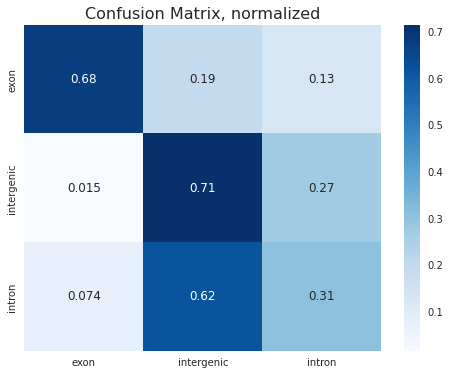

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


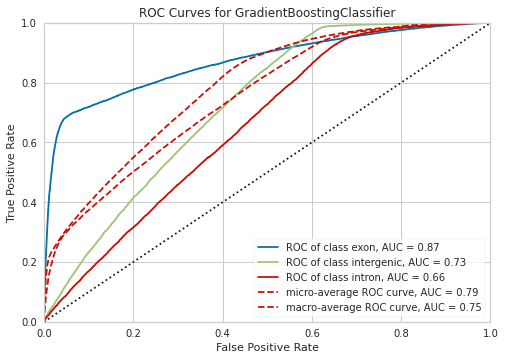

/home/lieberze/DP/Thesis/tokenizery_2_attempt/data/sample/Encoding/Encoded_512bp_1M_lines/CharBPE/All_1000/15000
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/home/lieberze/.conda/envs/bio/lib/python3.6/site-packages/sklearn/model_selection/_search.py:289: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


GradientBoostingClassifier(max_depth=7, max_features='sqrt',
                           min_samples_leaf=200, min_samples_split=3000,
                           random_state=42, subsample=0.8)
validation f1_score (weighted): 0.5627102973749581
test f1_score (weighted): 0.564722724660585
              precision    recall  f1-score      support
exon           0.890806  0.667904  0.763417  16697.00000
intergenic     0.462402  0.680586  0.550670  16643.00000
intron         0.433346  0.337755  0.379626  16660.00000
accuracy       0.562120  0.562120  0.562120      0.56212
macro avg      0.595518  0.562082  0.564571  50000.00000
weighted avg   0.595782  0.562120  0.564723  50000.00000


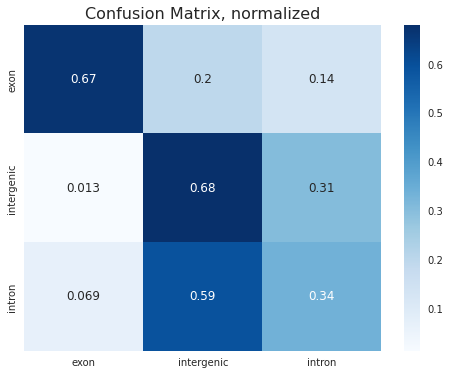

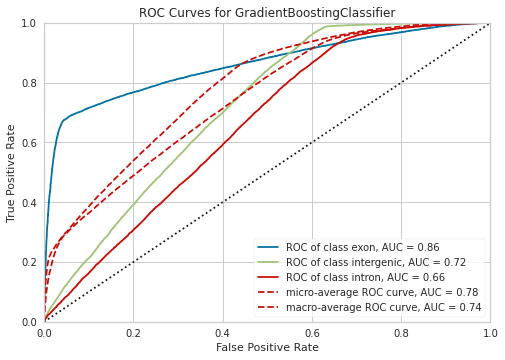

/home/lieberze/DP/Thesis/tokenizery_2_attempt/data/sample/Encoding/Encoded_512bp_1M_lines/CharBPE/All_1000/50000
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/home/lieberze/.conda/envs/bio/lib/python3.6/site-packages/sklearn/model_selection/_search.py:289: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


GradientBoostingClassifier(max_depth=8, max_features='sqrt',
                           min_samples_leaf=100, min_samples_split=3000,
                           random_state=42, subsample=0.8)
validation f1_score (weighted): 0.5626547425218419
test f1_score (weighted): 0.5661699427090671
              precision    recall  f1-score     support
exon           0.891744  0.663053  0.760580  16697.0000
intergenic     0.464690  0.607282  0.526502  16643.0000
intron         0.421661  0.400780  0.410956  16660.0000
accuracy       0.557100  0.557100  0.557100      0.5571
macro avg      0.592698  0.557039  0.566013  50000.0000
weighted avg   0.592963  0.557100  0.566170  50000.0000


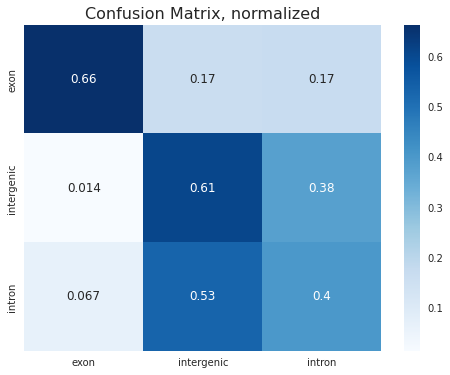

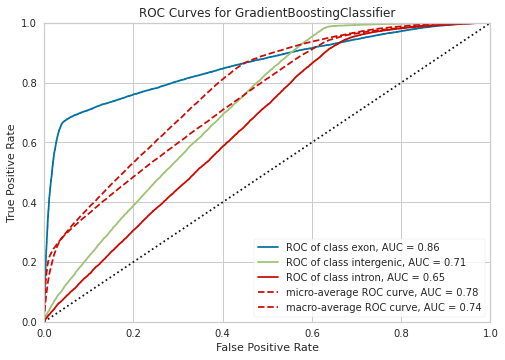

/home/lieberze/DP/Thesis/tokenizery_2_attempt/data/sample/Encoding/Encoded_512bp_1M_lines/CharBPE/All_512/5000
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/home/lieberze/.conda/envs/bio/lib/python3.6/site-packages/sklearn/model_selection/_search.py:289: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


GradientBoostingClassifier(max_depth=8, max_features='sqrt',
                           min_samples_leaf=100, min_samples_split=3000,
                           random_state=42, subsample=0.8)
validation f1_score (weighted): 0.5649788921521008
test f1_score (weighted): 0.5651935427496166
              precision    recall  f1-score      support
exon           0.882842  0.680122  0.768336  16697.00000
intergenic     0.467842  0.708045  0.563410  16643.00000
intron         0.435015  0.312005  0.363382  16660.00000
accuracy       0.566760  0.566760  0.566760      0.56676
macro avg      0.595233  0.566724  0.565043  50000.00000
weighted avg   0.595489  0.566760  0.565194  50000.00000


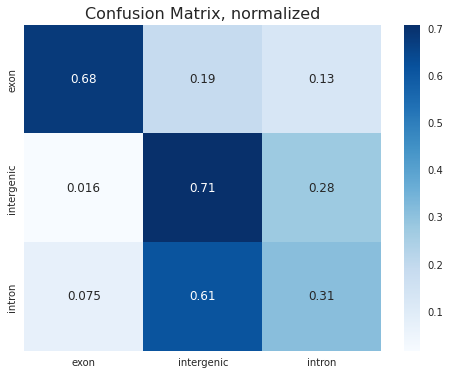

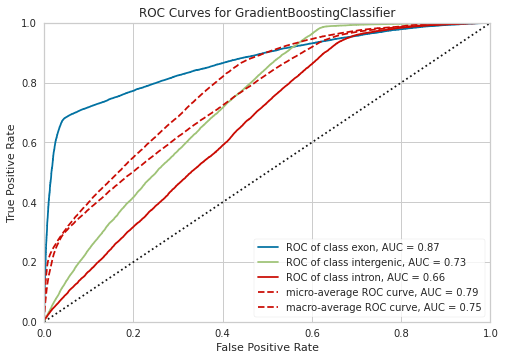

/home/lieberze/DP/Thesis/tokenizery_2_attempt/data/sample/Encoding/Encoded_512bp_1M_lines/CharBPE/All_512/15000
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/home/lieberze/.conda/envs/bio/lib/python3.6/site-packages/sklearn/model_selection/_search.py:289: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


GradientBoostingClassifier(max_depth=8, max_features='sqrt',
                           min_samples_leaf=150, min_samples_split=5000,
                           random_state=42, subsample=0.8)
validation f1_score (weighted): 0.5643743516888989
test f1_score (weighted): 0.5662750756745322
              precision    recall  f1-score     support
exon           0.890239  0.671318  0.765433  16697.0000
intergenic     0.466068  0.670973  0.550058  16643.0000
intron         0.428582  0.345978  0.382876  16660.0000
accuracy       0.562800  0.562800  0.562800      0.5628
macro avg      0.594963  0.562756  0.566122  50000.0000
weighted avg   0.595226  0.562800  0.566275  50000.0000


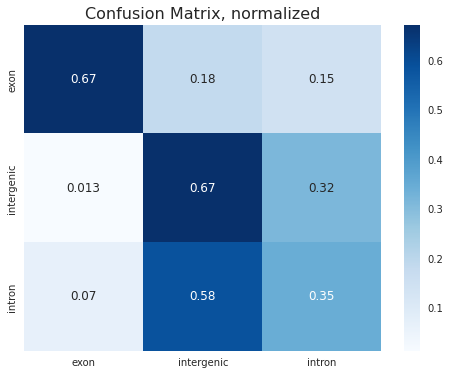

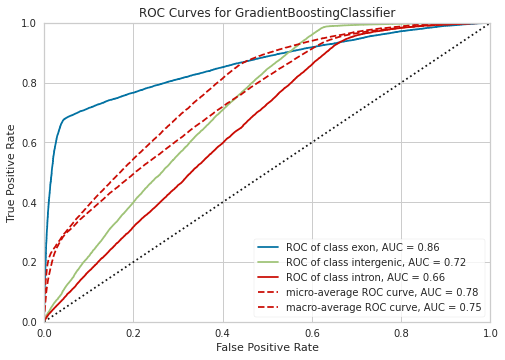

/home/lieberze/DP/Thesis/tokenizery_2_attempt/data/sample/Encoding/Encoded_512bp_1M_lines/CharBPE/All_512/50000
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [ ]:
train_size = 150000
test_size = 50000
measures = []
for Path in Paths:
    print(Path)
    X, y = LoadData(Path + "/encoded.txt")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state = RANDOM_STATE)
    
    #smaller_sample
    X_tr, y_tr =  X_train[:train_size], y_train[:train_size]
    X_te, y_te = X_test[:test_size], y_test[:test_size]

    BestScores = TryClassifiers(model_grid, RANDOM_STATE, X_tr, y_tr)
    model = PickBest(BestScores)
    
    # save model
    filename = '/classification_model.sav'
    joblib.dump(model, Path + filename)
    
    exon_vs_rest_f1_score_ = FitPredictGetMetrics(model, X_te, y_te)
    measures.append(exon_vs_rest_f1_score_)
    
    ROCAUCcurve(model, X_tr, y_tr, X_te, y_te)

## Continue the computation (it stopped again)

In [26]:
# Paths[5:]

/home/lieberze/DP/Thesis/tokenizery_2_attempt/data/sample/Encoding/Encoded_512bp_1M_lines/CharBPE/All_512/50000
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/home/lieberze/.conda/envs/bio/lib/python3.6/site-packages/sklearn/model_selection/_search.py:289: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


GradientBoostingClassifier(max_depth=7, max_features='sqrt',
                           min_samples_leaf=200, min_samples_split=3000,
                           random_state=42, subsample=0.8)
validation f1_score (weighted): 0.5633198514055475
test f1_score (weighted): 0.5629700793706578
              precision    recall  f1-score      support
exon           0.891498  0.663832  0.761002  16697.00000
intergenic     0.458710  0.619119  0.526978  16643.00000
intron         0.421081  0.381753  0.400453  16660.00000
accuracy       0.554960  0.554960  0.554960      0.55496
macro avg      0.590430  0.554901  0.562811  50000.00000
weighted avg   0.590697  0.554960  0.562970  50000.00000


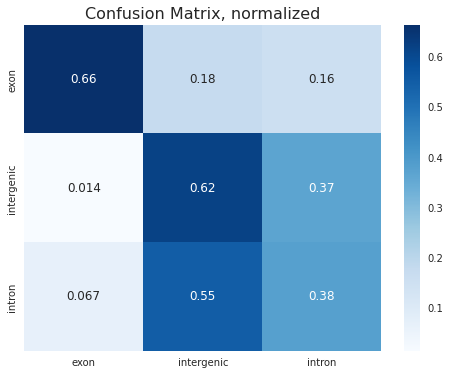

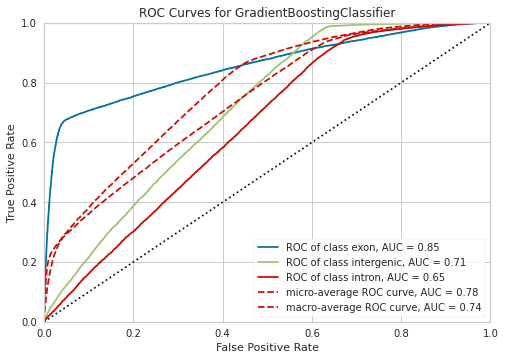

/home/lieberze/DP/Thesis/tokenizery_2_attempt/data/sample/Encoding/Encoded_512bp_1M_lines/ByteLevelBPE/All_1000/5000
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/home/lieberze/.conda/envs/bio/lib/python3.6/site-packages/sklearn/model_selection/_search.py:289: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


GradientBoostingClassifier(max_depth=8, max_features='sqrt',
                           min_samples_leaf=150, min_samples_split=5000,
                           random_state=42, subsample=0.8)
validation f1_score (weighted): 0.5645027752075663
test f1_score (weighted): 0.5628259198669614
              precision    recall  f1-score      support
exon           0.884171  0.678445  0.767766  16697.00000
intergenic     0.466938  0.722586  0.567291  16643.00000
intron         0.433657  0.297599  0.352970  16660.00000
accuracy       0.566240  0.566240  0.566240      0.56624
macro avg      0.594922  0.566210  0.562676  50000.00000
weighted avg   0.595180  0.566240  0.562826  50000.00000


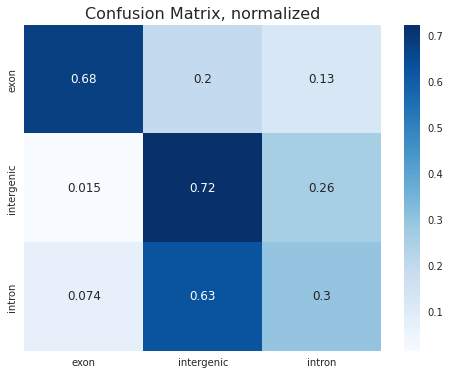

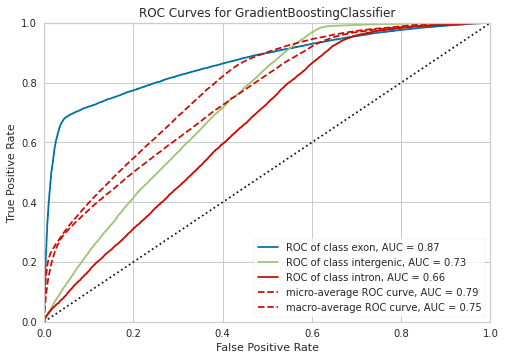

/home/lieberze/DP/Thesis/tokenizery_2_attempt/data/sample/Encoding/Encoded_512bp_1M_lines/ByteLevelBPE/All_1000/15000
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/home/lieberze/.conda/envs/bio/lib/python3.6/site-packages/sklearn/model_selection/_search.py:289: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/home/lieberze/.conda/envs/bio/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.71645e-17): result may not be accurate.
  overwrite_a=True).T


GradientBoostingClassifier(max_depth=7, max_features='sqrt',
                           min_samples_leaf=200, min_samples_split=3000,
                           random_state=42, subsample=0.8)
validation f1_score (weighted): 0.5641164698946856
test f1_score (weighted): 0.5641654702378961
              precision    recall  f1-score      support
exon           0.891420  0.670180  0.765128  16697.00000
intergenic     0.462527  0.679325  0.550344  16643.00000
intron         0.429516  0.335234  0.376563  16660.00000
accuracy       0.561620  0.561620  0.561620      0.56162
macro avg      0.594488  0.561580  0.564012  50000.00000
weighted avg   0.594752  0.561620  0.564165  50000.00000


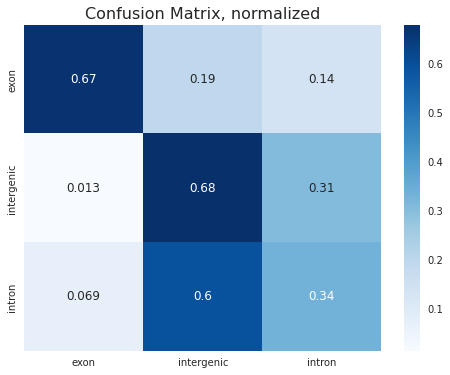

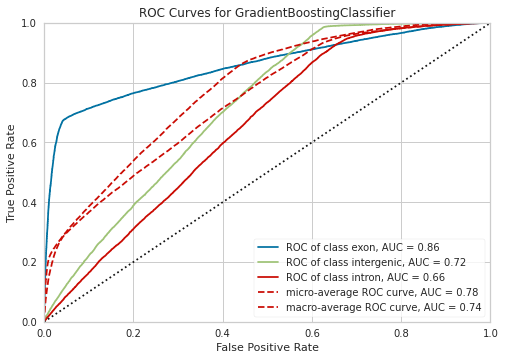

/home/lieberze/DP/Thesis/tokenizery_2_attempt/data/sample/Encoding/Encoded_512bp_1M_lines/ByteLevelBPE/All_1000/50000
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/home/lieberze/.conda/envs/bio/lib/python3.6/site-packages/sklearn/model_selection/_search.py:289: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/home/lieberze/.conda/envs/bio/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.56737e-17): result may not be accurate.
  overwrite_a=True).T


GradientBoostingClassifier(max_depth=8, max_features='sqrt',
                           min_samples_leaf=100, min_samples_split=3000,
                           random_state=42, subsample=0.8)
validation f1_score (weighted): 0.5637392928649282
test f1_score (weighted): 0.5656066677927087
              precision    recall  f1-score      support
exon           0.891689  0.663173  0.760639  16697.00000
intergenic     0.462220  0.607943  0.525160  16643.00000
intron         0.423209  0.398619  0.410546  16660.00000
accuracy       0.556640  0.556640  0.556640      0.55664
macro avg      0.592373  0.556579  0.565449  50000.00000
weighted avg   0.592639  0.556640  0.565607  50000.00000


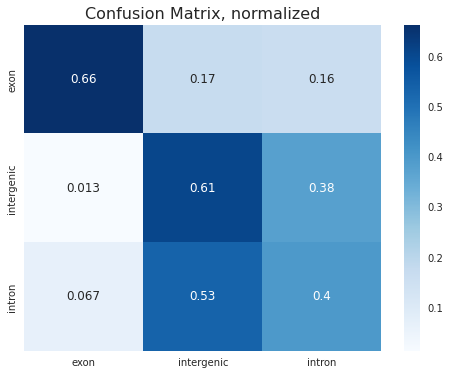

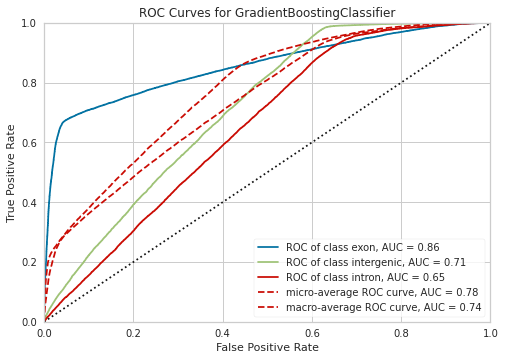

/home/lieberze/DP/Thesis/tokenizery_2_attempt/data/sample/Encoding/Encoded_512bp_1M_lines/ByteLevelBPE/All_512/5000
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/home/lieberze/.conda/envs/bio/lib/python3.6/site-packages/sklearn/model_selection/_search.py:289: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


GradientBoostingClassifier(max_depth=8, max_features='sqrt',
                           min_samples_leaf=100, min_samples_split=3000,
                           random_state=42, subsample=0.8)
validation f1_score (weighted): 0.5644028449636196
test f1_score (weighted): 0.5676293740744682
              precision    recall  f1-score      support
exon           0.883052  0.680601  0.768721  16697.00000
intergenic     0.469301  0.706363  0.563932  16643.00000
intron         0.439864  0.318968  0.369785  16660.00000
accuracy       0.568680  0.568680  0.568680      0.56868
macro avg      0.597406  0.568644  0.567479  50000.00000
weighted avg   0.597661  0.568680  0.567629  50000.00000


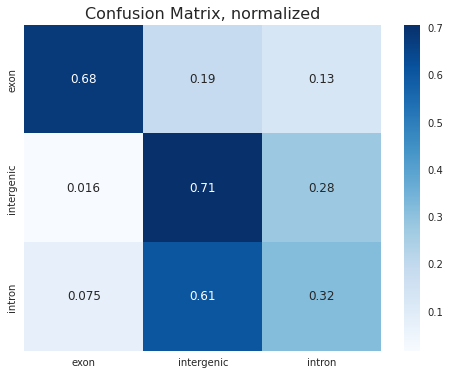

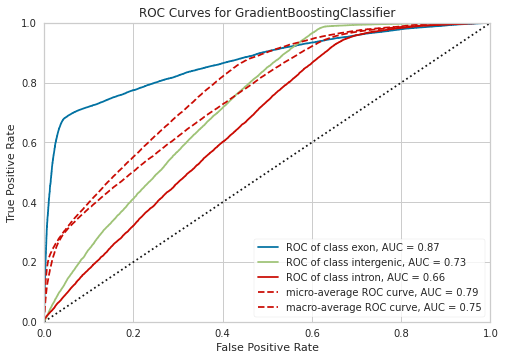

/home/lieberze/DP/Thesis/tokenizery_2_attempt/data/sample/Encoding/Encoded_512bp_1M_lines/ByteLevelBPE/All_512/15000
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/home/lieberze/.conda/envs/bio/lib/python3.6/site-packages/sklearn/model_selection/_search.py:289: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/home/lieberze/.conda/envs/bio/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.95502e-17): result may not be accurate.
  overwrite_a=True).T


GradientBoostingClassifier(max_depth=8, max_features='sqrt',
                           min_samples_leaf=100, min_samples_split=3000,
                           random_state=42, subsample=0.8)
validation f1_score (weighted): 0.5635363153208798
test f1_score (weighted): 0.5658766163123483
              precision    recall  f1-score      support
exon           0.890513  0.671258  0.765495  16697.00000
intergenic     0.465658  0.671333  0.549893  16643.00000
intron         0.427869  0.344658  0.381782  16660.00000
accuracy       0.562460  0.562460  0.562460      0.56246
macro avg      0.594680  0.562416  0.565723  50000.00000
weighted avg   0.594943  0.562460  0.565877  50000.00000


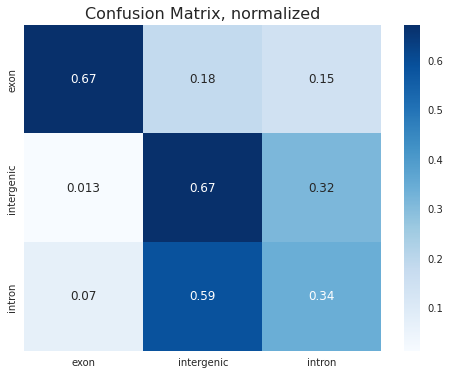

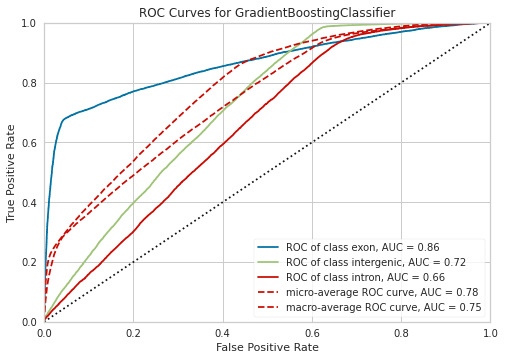

/home/lieberze/DP/Thesis/tokenizery_2_attempt/data/sample/Encoding/Encoded_512bp_1M_lines/ByteLevelBPE/All_512/50000
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/home/lieberze/.conda/envs/bio/lib/python3.6/site-packages/sklearn/model_selection/_search.py:289: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/home/lieberze/.conda/envs/bio/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.09932e-17): result may not be accurate.
  overwrite_a=True).T


GradientBoostingClassifier(max_depth=7, max_features='sqrt',
                           min_samples_leaf=200, min_samples_split=3000,
                           random_state=42, subsample=0.8)
validation f1_score (weighted): 0.5641066841231069
test f1_score (weighted): 0.5637205812014087
              precision    recall  f1-score      support
exon           0.892544  0.664610  0.761895  16697.00000
intergenic     0.459070  0.620681  0.527781  16643.00000
intron         0.422237  0.381813  0.401009  16660.00000
accuracy       0.555760  0.555760  0.555760      0.55576
macro avg      0.591284  0.555702  0.563562  50000.00000
weighted avg   0.591552  0.555760  0.563721  50000.00000


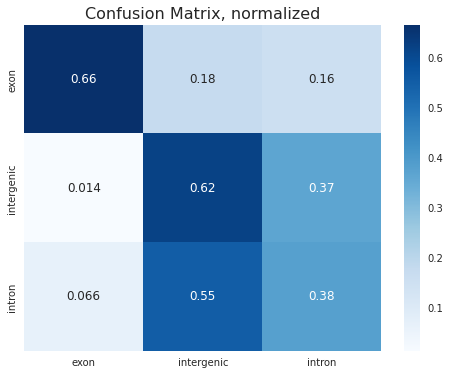

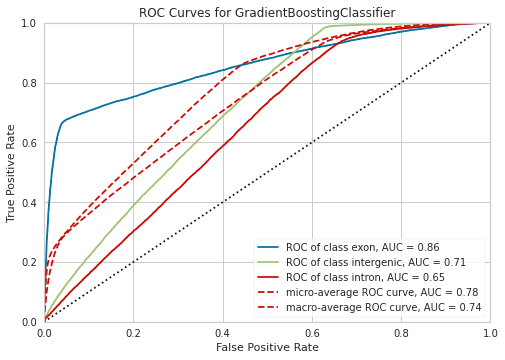

In [27]:
train_size = 150000
test_size = 50000
# measures = [] # IMPORTANT TO COMMENT OUT
for Path in Paths[5:]:
    print(Path)
    X, y = LoadData(Path + "/encoded.txt")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state = RANDOM_STATE)
    
    #smaller_sample
    X_tr, y_tr =  X_train[:train_size], y_train[:train_size]
    X_te, y_te = X_test[:test_size], y_test[:test_size]

    BestScores = TryClassifiers(model_grid, RANDOM_STATE, X_tr, y_tr)
    model = PickBest(BestScores)
    
    # save model
    filename = '/classification_model.sav'
    joblib.dump(model, Path + filename)
    
    exon_vs_rest_f1_score_ = FitPredictGetMetrics(model, X_te, y_te)
    measures.append(exon_vs_rest_f1_score_)
    
    ROCAUCcurve(model, X_tr, y_tr, X_te, y_te)

## Pick the best score (tokenizer)

In [28]:
# how to evaluate? look at the ratio (measures[2])?
for p, m in zip(Paths, measures):
    print(p)
    print(m)

/home/lieberze/DP/Thesis/tokenizery_2_attempt/data/sample/Encoding/Encoded_512bp_1M_lines/CharBPE/All_1000/5000
(0.7681571815718158, 0.9270068387287389, 0.828642410691637)
/home/lieberze/DP/Thesis/tokenizery_2_attempt/data/sample/Encoding/Encoded_512bp_1M_lines/CharBPE/All_1000/15000
(0.7634173055859802, 0.9302952500740929, 0.8206182988950854)
/home/lieberze/DP/Thesis/tokenizery_2_attempt/data/sample/Encoding/Encoded_512bp_1M_lines/CharBPE/All_1000/50000
(0.760579829623523, 0.937457758588707, 0.811321707730635)
/home/lieberze/DP/Thesis/tokenizery_2_attempt/data/sample/Encoding/Encoded_512bp_1M_lines/CharBPE/All_512/5000
(0.7683355886332882, 0.9267920637792968, 0.8290269399806353)
/home/lieberze/DP/Thesis/tokenizery_2_attempt/data/sample/Encoding/Encoded_512bp_1M_lines/CharBPE/All_512/15000
(0.765432941819175, 0.9329334296572203, 0.8204582636731235)
/home/lieberze/DP/Thesis/tokenizery_2_attempt/data/sample/Encoding/Encoded_512bp_1M_lines/CharBPE/All_512/50000
(0.7610024030209405, 0.9274

In [52]:
new_measures = []
for p, m in zip(Paths, measures):
    X = "-".join(p.split("/")[-3:])
    new_measures.append([X, m])
new_measures

[['CharBPE-All_1000-5000',
  (0.7681571815718158, 0.9270068387287389, 0.828642410691637)],
 ['CharBPE-All_1000-15000',
  (0.7634173055859802, 0.9302952500740929, 0.8206182988950854)],
 ['CharBPE-All_1000-50000',
  (0.760579829623523, 0.937457758588707, 0.811321707730635)],
 ['CharBPE-All_512-5000',
  (0.7683355886332882, 0.9267920637792968, 0.8290269399806353)],
 ['CharBPE-All_512-15000',
  (0.765432941819175, 0.9329334296572203, 0.8204582636731235)],
 ['CharBPE-All_512-50000',
  (0.7610024030209405, 0.9274313007543299, 0.8205485434899341)],
 ['ByteLevelBPE-All_1000-5000',
  (0.7677657663763598, 0.9202614008181942, 0.8342909587360154)],
 ['ByteLevelBPE-All_1000-15000',
  (0.765128205128205, 0.9269077866458018, 0.8254631325268849)],
 ['ByteLevelBPE-All_1000-50000',
  (0.760638845955693, 0.9357067408764408, 0.8129030311817905)],
 ['ByteLevelBPE-All_512-5000',
  (0.7687208279780829, 0.9337169193332715, 0.8232910982559838)],
 ['ByteLevelBPE-All_512-15000',
  (0.7654953385923573, 0.93167486

In [53]:
# measures
# zprumerovat do diplomky(?)
# vzit neco z 512 bp

In [54]:
sorted_by_third = sorted(new_measures, key=lambda tup: tup[1][2], reverse=True)
sorted_by_third

[['ByteLevelBPE-All_1000-5000',
  (0.7677657663763598, 0.9202614008181942, 0.8342909587360154)],
 ['CharBPE-All_512-5000',
  (0.7683355886332882, 0.9267920637792968, 0.8290269399806353)],
 ['CharBPE-All_1000-5000',
  (0.7681571815718158, 0.9270068387287389, 0.828642410691637)],
 ['ByteLevelBPE-All_1000-15000',
  (0.765128205128205, 0.9269077866458018, 0.8254631325268849)],
 ['ByteLevelBPE-All_512-5000',
  (0.7687208279780829, 0.9337169193332715, 0.8232910982559838)],
 ['ByteLevelBPE-All_512-15000',
  (0.7654953385923573, 0.9316748695900758, 0.8216335586352831)],
 ['CharBPE-All_1000-15000',
  (0.7634173055859802, 0.9302952500740929, 0.8206182988950854)],
 ['CharBPE-All_512-50000',
  (0.7610024030209405, 0.9274313007543299, 0.8205485434899341)],
 ['CharBPE-All_512-15000',
  (0.765432941819175, 0.9329334296572203, 0.8204582636731235)],
 ['ByteLevelBPE-All_512-50000',
  (0.7618949536560247, 0.928789994082537, 0.8203091748513376)],
 ['ByteLevelBPE-All_1000-50000',
  (0.760638845955693, 0.93